# MuJoCo basics

We begin by defining and loading a simple model:

In [16]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time
import itertools
import numpy as np

# Example: Simulating free bodies with the self-inverting "tippe-top"

A free body is a body with a [free joint](https://www.google.com/url?sa=D&q=https%3A%2F%2Fmujoco.readthedocs.io%2Fen%2Flatest%2FXMLreference.html%3Fhighlight%3Dfreejoint%23body-freejoint) having 6 DoFs, i.e., 3 translations and 3 rotations. We could give our `box_and_sphere` body a free joint and watch it fall, but let's look at something more interesting. A "tippe top" is a spinning toy which flips itself ([video](https://www.youtube.com/watch?v=kbYpVrdcszQ), [Wikipedia](https://en.wikipedia.org/wiki/Tippe_top)). We model it as follows:

""

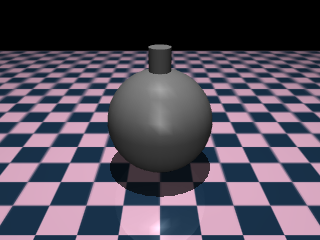

In [17]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".9 .7 .8" width="1000" height="1000"/>
    <material name="grid" texture="grid" texrepeat="16 16" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" pos="0 0 0" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
try:
  renderer
except:
  renderer = mujoco.Renderer(model)
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)  # В явном виде записали данные в структуру данных mujoco.data
renderer.update_scene(data, camera="closeup")
media.show_image(renderer.render())

Note several new features of this model definition:
1. A 6-DoF free joint is added with the `<freejoint/>` clause.
2. We use the `<option/>` clause to set the integrator to the 4th order [Runge Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). Runge-Kutta has a higher rate of convergence than the default Euler integrator, which in many cases increases the accuracy at a given timestep size.
3. We define the floor's grid material inside the `<asset/>` clause and reference it in the `"floor"` geom.
4. We use an invisible and non-colliding box geom called `ballast` to move the top's center-of-mass lower. Having a low center of mass is (counter-intuitively) required for the flipping behavior to occur.
5. We save our initial spinning state as a *keyframe*. It has a high rotational velocity around the Z-axis, but is not perfectly oriented with the world, which introduces the symmetry-breaking required for the flipping.
6. We define a `<camera>` in our model, and then render from it using the `camera` argument to `update_scene()`.
Let us examine the state:


In [18]:
print('positions', data.qpos)   # x, y, z, quaternion(4x1)
print('velocities', data.qvel)  # vx, vy, vz, wx, wy, wz

positions [0.   0.   0.02 1.   0.   0.   0.  ]
velocities [0. 0. 0. 0. 0. 0.]


The velocities are easy to interpret, 6 zeros, one for each DoF. What about the length 7 positions? We can see the initial 2cm height of the body; the subsequent four numbers are the 3D orientation, defined by a *unit quaternion*. 3D orientations are represented with **4** numbers while angular velocities are **3** numbers. For more information see the Wikipedia article on [quaternions and spatial rotation](https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation).

Let's make a video:

In [19]:
duration = 7    # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetDataKeyframe(model, data, 0)  # Reset the state to keyframe 0
# mujoco.mj_resetData(model, data)  # Этот сброс не подойдет, так как он не выставит начальный keyframe
while data.time < duration:
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data, "closeup")  # Обновление сцены при помощи заданное камеры
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

### Measuring values from `mjData`
As mentioned above, the `mjData` structure contains the dynamic variables and intermediate results produced by the simulation which are *expected to change* on each timestep. Below we simulate for 2000 timesteps and plot the angular velocity of the top and height of the stem as a function of time.

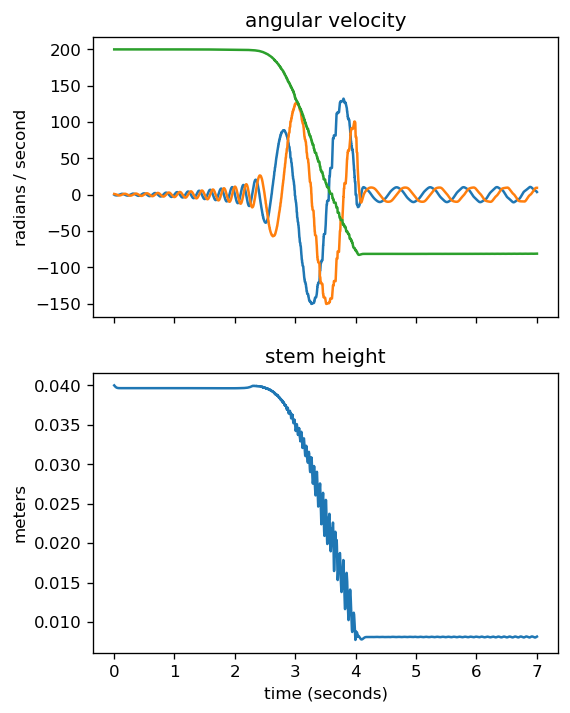

In [20]:
timevals = []
angular_velocity = []
stem_height = []

# Simulate and save data
mujoco.mj_resetDataKeyframe(model, data, 0)
while data.time < duration:
  mujoco.mj_step(model, data)
  timevals.append(data.time)
  angular_velocity.append(data.qvel[3:6].copy())
  stem_height.append(data.geom_xpos[2,2])

dpi = 120
width = 600
height = 800
figsize = (width / dpi, height / dpi)
_, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi, sharex=True)

ax[0].plot(timevals, angular_velocity)
ax[0].set_title('angular velocity')
ax[0].set_ylabel('radians / second')

ax[1].plot(timevals, stem_height)
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('meters')
_ = ax[1].set_title('stem height')